# Data extraction and merging


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import os
import pickle
import codecs
import re
from tqdm import tqdm_notebook as tqdm

#For tokenizing sentences
import nltk
nltk.download('punkt')
plt.style.use('seaborn-whitegrid')

# Cte
BASE_PATH = "../data/"

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/salhilamia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/var/folders/my/5lwd7z794l5ch10f821f_jkm0000gn/T/ipykernel_5447/3106827710.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [14]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import codecs
import io
from lxml import etree
from dateutil.relativedelta import *

import seaborn as sns; sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import re
import pickle
from tqdm.notebook import tqdm

import nltk

## utils

### Reading the data

Nous avons 6 fichiers CSV :
- Statements : YES available right after each FOMC meeting
- Meeting Minutes : No because available three weeks after each FOMC meeting
- Press Conference Transcripts : YES to check
- Meeting Transcripts : NO available five years after the meeting
- Speeches : A considerer ça peut être interessant
- Testimony : 'Semiannual Monetary Policy Report to the Congress'

In [1349]:
market_data_df = pd.read_csv("../data/dataset/agglomerate/agglomerate_fill_with_range_v2.csv", index_col=0)
market_data_sentiment = pd.read_csv("../data/dataset/agglomerate/agglomerate_filled_sentiment.csv")
columns = list(market_data_df.columns)

In [1350]:
market_data_sentiment.columns

Index(['date', 'w.bcpi_BCPI_WEEKLY', 'w.bcne_BCPI_WEEKLY',
       'w.ener_BCPI_WEEKLY', 'w.mtls_BCPI_WEEKLY', 'w.fopr_BCPI_WEEKLY',
       'w.agri_BCPI_WEEKLY', 'w.fish_BCPI_WEEKLY', 'v39078_CA.-interest_rate',
       'v121820_U.S.-interest_rate', 'value_FRED_CPIAUCSL', 'value_FRED_DFF',
       'value_FRED_GDPC1', 'value_FRED_GDPPOT', 'value_FRED_HSN1F',
       'value_FRED_PAYEMS', 'value_FRED_PCEPILFE', 'value_FRED_RRSFS',
       'value_FRED_UNRATE', 'fxusdcad_FXUSDCAD_rsi', 'rsi_FXUSDCAD_rsi',
       'pmi_ISM_MAN_PMI', 'index_ISM_NONMAN_NMI', '1 mo_USTREASURY_YIELD',
       'canada_bank_sentiment_last_week', 'canada_bank_sentiment_last_2week',
       'canada_bank_sentiment_last_month',
       'fomc_statement_sentiment_last_week',
       'fomc_statement_sentiment_last_2week',
       'fomc_statement_sentiment_last_month',
       'fomc_meeting_sentiment_last_week', 'fomc_meeting_sentiment_last_2week',
       'fomc_meeting_sentiment_last_month', 'fomc_minutes_sentiment_last_week',
      

In [2030]:
market_data_df = pd.read_csv("../data/dataset/agglomerate/agglomerate_fill_with_range_v2.csv", index_col=0)
market_data_sentiment = pd.read_csv("../data/dataset/agglomerate/agglomerate_filled_sentiment.csv")
columns = list(market_data_df.columns)

market_data_df = market_data_df.drop(columns[:20]+columns[20:], axis=1)
#market_data_df = market_data_df.drop(list(market_data_df.columns)[3:], axis=1)
market_data_df["date"] = market_data_sentiment["date"]
market_data_df["fxusdcad_FXUSDCAD_rsi"] = market_data_sentiment["fxusdcad_FXUSDCAD_rsi"]
market_data_df["fomc_statement_sentiment_last_week"] = market_data_sentiment["fomc_statement_sentiment_last_week"]
market_data_df["canada_bank_sentiment_last_week"] = market_data_sentiment["canada_bank_sentiment_last_week"]
#market_data_df["fomc_presconf_sentiment_last_week"] = market_data_sentiment["fomc_presconf_sentiment_last_week"]
#market_data_df["fomc_minutes_sentiment_last_week"] = market_data_sentiment["fomc_minutes_sentiment_last_week"]
market_data_df["fomc_testimony_sentiment_last_week"] = market_data_sentiment["fomc_testimony_sentiment_last_week"]
market_data_df.head()

,date,fxusdcad_FXUSDCAD_rsi,fomc_statement_sentiment_last_week,canada_bank_sentiment_last_week,fomc_testimony_sentiment_last_week
0,2017-01-04,1.331500,0.011111,0.014098,0.007442
1,2017-01-05,1.324400,0.022222,0.028195,0.014884
2,2017-01-06,1.321400,0.033333,0.042293,0.022326
3,2017-01-07,1.322267,0.044444,0.056391,0.029767
4,2017-01-08,1.323133,0.055556,0.070489,0.037209


## Evaluation

In [2031]:
# fill nanq of market_data_df

In [2032]:
import pandas as pd
from sklearn.metrics import mean_squared_error

def evaluate(pred_df: pd.DataFrame, test_path_csv: str) -> float:
    # Open test data
    test_df = pd.read_csv(test_path_csv)

    # Format data
    test_df['date'] = pd.to_datetime(test_df['date'], format='%Y-%m-%d')
    pred_df['date'] = pd.to_datetime(pred_df['date'], format='%Y-%m-%d')

    # Inner joint dataframe
    test_pred = test_df.merge(pred_df, on="date", how="inner")
    
    # Extract y true and y pred
    y_true = test_pred.FXUSDCAD_x.to_numpy()
    y_pred = test_pred.FXUSDCAD_y.to_numpy()

    mse = mean_squared_error(y_true, y_pred)
    print(f" Mean squared error: {mse}")

    # TODO: Add other metrics

    return mse

## remarks

Remarque sur les textes : 
- supprimer "[SECTION]", les "\n", les lists de nom de personnes du style "Jerome H. Powell, Chair; John C. Williams, Vice Chair; Michael S. Barr;"


List des mots redondants à supprimer (à plots):
- Committee
- les dates
- le début des textes

## baseline model XGboost and Logistic regression with the features selected

In [2033]:
df2 = market_data_df.corr()

In [2034]:
import seaborn as sns
%matplotlib inline
sns.set(rc={'figure.figsize':(13,13)})
#df2 = df2.drop(market_data_df.columns[-11:]).drop(market_data_df.columns[-11:], axis=1)
#df2= df2.drop(market_data_df.columns[12]).drop(df_market_features.columns[12], axis=1)
#df2 = df2.drop(market_data_df.columns[13]).drop(df_market_features.columns[13], axis=1)

<AxesSubplot:title={'center':'Correlation between market data'}>

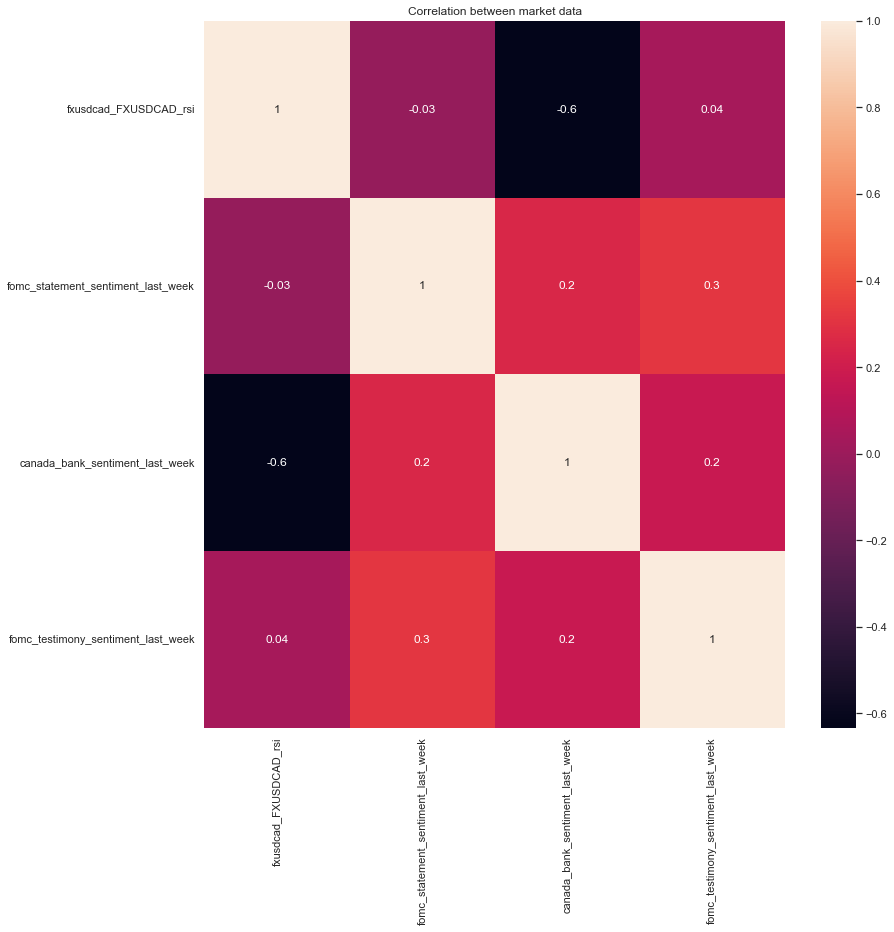

In [2035]:
plt.title("Correlation between market data")
sns.heatmap(df2, annot=True, fmt=".1g")

## split train_test set

In [2036]:
import pandas as pd
BASE_PATH = "../data"
def split_and_save(df: pd.DataFrame, date_split='2022-05-01', filename_prefix=None, output_path='', keep_index=False):
    """ Simple function to split data set """
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

    # Split data
    """ Train data """
    train = df.loc[(df['date'] < date_split)]
    """ Test data """
    test = df.loc[(df['date'] >= date_split)]

    # Save Value
    if filename_prefix != None:
        train.to_csv(f"{BASE_PATH}/train/{output_path}/{filename_prefix}.csv", index=keep_index)
        test.to_csv(f"{BASE_PATH}/test/{output_path}/{filename_prefix}.csv", index=keep_index)
    
    return train, test


In [2037]:
train, test = split_and_save(market_data_df,filename_prefix="dataset", output_path="version1")

## x and y split

In [2038]:
test.columns

Index(['date', 'fxusdcad_FXUSDCAD_rsi', 'fomc_statement_sentiment_last_week',
       'canada_bank_sentiment_last_week',
       'fomc_testimony_sentiment_last_week'],
      dtype='object')

In [2039]:
X_train,y_train = train.drop(['fxusdcad_FXUSDCAD_rsi','date'], axis=1).to_numpy(),train['fxusdcad_FXUSDCAD_rsi'].values
X_test, y_test = test.drop(['fxusdcad_FXUSDCAD_rsi','date'], axis=1).to_numpy(),test['fxusdcad_FXUSDCAD_rsi'].values

In [2040]:
X_train

array([[ 0.01111111,  0.01409774,  0.00744186],
       [ 0.02222222,  0.02819549,  0.01488372],
       [ 0.03333333,  0.04229323,  0.02232558],
       ...,
       [-0.05496829,  0.17342648, -0.16193606],
       [-0.05902044,  0.17216664, -0.16709259],
       [-0.06307259,  0.17090681, -0.17224912]])

## model simple XGboost

In [2041]:
import xgboost
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
print(xgboost.__version__)

1.6.1


In [2042]:
model = XGBRegressor(n_estimators=1000, max_depth=5, eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [2043]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(model, np.array(X_train), y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [2044]:
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.006 (0.000)


In [2045]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, ...)

In [2046]:
y_test_pred  = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [2047]:
mean_squared_error(y_train, y_train_pred)

1.0163964072328459e-06

In [2048]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
print(f" Mean squared error: {mse}\n r2 score: {r2}")

 Mean squared error: 0.000418467031647579
 r2 score: 0.622469729311272


### Random forest

In [2049]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=7, random_state=0, n_estimators=100)

In [2015]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(model, np.array(X_train), y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [2016]:
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.010 (0.001)


In [2017]:
X_train.shape

(1943, 4)

In [2018]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, random_state=0)

In [2019]:
y_test_pred  = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [2020]:
print(mean_squared_error(y_train, y_train_pred))
print(r2_score(y_train, y_train_pred))

0.00017636188281881034
0.9032689416751364


In [2021]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
print(f" Mean squared error: {mse}\n r2 score: {r2}")

 Mean squared error: 0.0010115104141489102
 r2 score: 0.08744113256761787


### Linear regression

In [2022]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [2023]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(model, np.array(X_train), y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [2024]:
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.025 (0.001)


In [2025]:
model.fit(X_train, y_train)

LinearRegression()

In [2026]:
y_test_pred  = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [2027]:
mean_squared_error(y_train, y_train_pred)

0.0010190724503757824

In [2028]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
print(f" Mean squared error: {mse}\n r2 score: {r2}")

 Mean squared error: 0.0008478449482655445
 r2 score: 0.23509593680409724


### SVR

In [1987]:
from sklearn.svm import SVR
model = SVR(kernel="linear", coef0=1, C=0.1, epsilon=0.2)

In [1988]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(model, np.array(X_train), y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [1989]:
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.039 (0.001)


In [1990]:
model.fit(X_train, y_train)

SVR(C=0.1, coef0=1, epsilon=0.2, kernel='linear')

In [1991]:
y_test_pred  = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [1992]:
mean_squared_error(y_train, y_train_pred)

0.0024975395771430196

In [1993]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
print(f" Mean squared error: {mse}\n r2 score: {r2}")

 Mean squared error: 0.0015700181535947704
 r2 score: -0.4164302888549425


### MLP Regressor

In [1761]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [1762]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [1763]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(100, 1000, 100), random_state=1, max_iter=500)

In [1764]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(model, np.array(X_train), y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [1765]:
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.018 (0.001)


In [1766]:
model.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(100, 1000, 100), max_iter=500, random_state=1)

In [1767]:
y_test_pred  = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [1768]:
mean_squared_error(y_train, y_train_pred)

0.0004541680617724393

In [1769]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
print(f" Mean squared error: {mse}\n r2 score: {r2}")

 Mean squared error: 0.0013609795923837857
 r2 score: -0.22784103658422095


In [1770]:
y_test_pred

array([1.28059809, 1.28198406, 1.28555501, 1.29838269, 1.31106305,
       1.31228662, 1.30954389, 1.30733825, 1.30485196, 1.28232301,
       1.28059097, 1.29071478, 1.28931143, 1.29257553, 1.2961463 ,
       1.29885464, 1.29811851, 1.28767173, 1.2991808 , 1.30692322,
       1.30875786, 1.31031035, 1.31190089, 1.31340378, 1.30080394,
       1.30011927, 1.30554753, 1.31053034, 1.31372767, 1.31612231,
       1.3209635 , 1.31758079, 1.37170951, 1.35923804, 1.35344371,
       1.34651178, 1.34025583, 1.32659477, 1.30275513, 1.29737368,
       1.28059207, 1.28322278, 1.28696468, 1.29294541, 1.31176074,
       1.31068717, 1.30359346, 1.32526424, 1.32394068, 1.32299742,
       1.32177462, 1.30644318, 1.2988602 , 1.28799447, 1.27796763,
       1.27223775, 1.26778514, 1.26409151, 1.2580484 , 1.25735392,
       1.26348273, 1.26583415, 1.27003551, 1.27321027, 1.27789573,
       1.29067636, 1.25568098, 1.25133549, 1.27343388, 1.27071104,
       1.26822385, 1.26705165, 1.2604213 , 1.25953234, 1.26090

### LSTM

In [1771]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [1772]:
tf.random.set_seed(7)

In [1773]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
testX = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [1774]:
# create and fit the LSTM network
model = Sequential()
model.add(SimpleRNN(64, input_shape=(1, trainX.shape[2]), return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(trainX, y_train, epochs=100, batch_size=1, verbose=2)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_17 (SimpleRNN)   (None, 1, 64)             4416      
                                                                 
 simple_rnn_18 (SimpleRNN)   (None, 1, 32)             3104      
                                                                 
 dense_13 (Dense)            (None, 1, 1)              33        
                                                                 
Total params: 7,553
Trainable params: 7,553
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1943/1943 - 3s - loss: 0.0408 - 3s/epoch - 1ms/step
Epoch 2/100
1943/1943 - 2s - loss: 0.0064 - 2s/epoch - 954us/step
Epoch 3/100
1943/1943 - 2s - loss: 0.0039 - 2s/epoch - 939us/step
Epoch 4/100
1943/1943 - 2s - loss: 0.0025 - 2s/epoch - 875us/step
Epoch 5/100
1943/1943 - 2s - loss: 0.0022 - 2s/epoch 

In [1775]:
y_test_pred  = model.predict(testX)
y_train_pred = model.predict(trainX)

In [1776]:
print(mean_squared_error(y_train, y_train_pred.reshape(-1)))
print(r2_score(y_train, y_train_pred.reshape(-1)))

0.0003796921854612931
0.7917462302492841


In [1777]:
print(mean_squared_error(y_test, y_test_pred.reshape(-1)))
print(r2_score(y_test, y_test_pred.reshape(-1)))

0.001185787065320302
-0.06978681208650461


## model simple XGboost

In [1005]:
y_test_pred

array([[[1.2590377]],

       [[1.2590308]],

       [[1.2589427]],

       [[1.2587725]],

       [[1.2584879]],

       [[1.2583025]],

       [[1.258096 ]],

       [[1.2578684]],

       [[1.2576202]],

       [[1.2573515]],

       [[1.2570629]],

       [[1.2567811]],

       [[1.256474 ]],

       [[1.2561431]],

       [[1.25579  ]],

       [[1.2554162]],

       [[1.2550237]],

       [[1.254615 ]],

       [[1.254151 ]],

       [[1.2536736]],

       [[1.2531866]],

       [[1.2526939]],

       [[1.2522005]],

       [[1.2517105]],

       [[1.25123  ]],

       [[1.2514653]],

       [[1.2517029]],

       [[1.2521031]],

       [[1.2525058]],

       [[1.2529106]],

       [[1.253317 ]],

       [[1.2537246]],

       [[1.2539185]],

       [[1.2546835]],

       [[1.2554411]],

       [[1.2561901]],

       [[1.256929 ]],

       [[1.2576566]],

       [[1.2583717]],

       [[1.2588725]],

       [[1.259365 ]],

       [[1.2598495]],

       [[1.260327 ]],

       [[1.

## 2.Data Cleaning

### 2.1.Remove punctuations

### 2.2 Word Replacement
### 2.3 Remove stopwords¶
### 2.4 Stemming/Lammetization - Tranforming any form of a word to its root word¶
### 2.5.a Stemming
### 2.5.b Lemmatization
### 2.6 plots